# Web Crawler

Collect text data from the PTT forum, process the article texts, and finally create a word cloud for a quick overview of the topics in these collected texts.

## Crawling Data from PTT

In [1]:
import requests
from bs4 import BeautifulSoup as soup  # HTML data structure
from lxml import etree


# extract article hyperlinks from an index page
def extractArtLinks(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    containers = page_soup.findAll("div", {"class": "r-ent"})
    art_links = []
    for container in containers:
        # Finds all link tags "a" from within the first div.
        art_link = container.find('a')
        if art_link:
            #print(art_link['href'])
            #print(container.find('div',{'class':'title'}).get_text())
            art_meta = container.find('div', {'class': 'meta'})
            #print(art_meta.find('div',{'class':'author'}).get_text())
            #print(art_meta.find('div',{'class':'date'}).get_text())

            art_links.append({
                'push':
                container.find('div', {
                    'class': 'nrec'
                }).get_text(),
                'title':
                container.find('div', {
                    'class': 'title'
                }).get_text().strip(),
                'date':
                art_meta.find('div', {
                    'class': 'date'
                }).get_text(),
                'author':
                art_meta.find('div', {
                    'class': 'author'
                }).get_text(),
                'link':
                art_link['href'],
                'text':
                extractArtText('https://www.ptt.cc' + art_link['href'])
            })

    return (art_links)


# find the previous index page link
def findPrevIndex(url):
    r = requests.get(url, cookies={'over18': '1'})
    page_soup = soup(r.text, "html.parser")
    btn = page_soup.select('div.btn-group > a')
    up_page_href = btn[3]['href']
    next_page_url = 'https://www.ptt.cc' + up_page_href
    return (next_page_url)


# extract article contents from  the article hyperlink
def extractArtText(url):
    r = requests.get(url, cookies={'over18': '1'})
    #page_soup = soup(r.text, "lxml")
    #print(page_soup.find("div",{"id":"main-content"}).get_text())
    #art_text=page_soup.select('div#main-content', limit=1)[0].text
    content = r.content.decode()
    html = etree.HTML(content)
    art_text = html.xpath(
        "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]"
    )
    return ''.join(list(art_text))

In [2]:
## Debug Use

# url = 'https://www.ptt.cc/bbs/Food/M.1602332821.A.6F3.html'
# r = requests.get(url, cookies={'over18': '1'})
# #page_soup = soup(r.text, "lxml")
# #print(page_soup.find("div",{"id":"main-content"}).get_text())
# #art_text=page_soup.select('div#main-content', limit=1)[0].text
# content = r.content.decode()
# html = etree.HTML(content)
# art_text = html.xpath(
#     "//div[@id='main-content']/text()[not(self::div|self::span[@class='f2'])]")

# print(''.join(list(art_text)))

```{note}
For CSS selector, don't know how to set conditional criteria to select only texts under div#main-container but not those included in the child div.article-metaline and span.f2.

So here I use the XPath, which requires the lxml package.
```

In [3]:
# main()
num_of_index_page = 5
board_name = 'Food'
url = 'https://www.ptt.cc/bbs/{}/index.html'.format(board_name)
all_links = []
for page in range(1, num_of_index_page):
    all_links = all_links + extractArtLinks(url)
    url = findPrevIndex(url)
len(all_links)

75

In [4]:
type(all_links[2])
print(all_links[2])

{'push': '', 'title': '[食記] 台北大安 Boulangerie Ours', 'date': '10/30', 'author': 'thudadai', 'link': '/bbs/Food/M.1604065630.A.942.html', 'text': '\n\n   餐廳名稱：Boulangerie Ours\n   消費時間：2020年/10月\n   地址：台北市大安區四維路375-3號\n   營業時間：AM11:00~PM6:00 (周三休)\n\n圖文版：\n\n\n最近開幕就紅起來的麵包店，據我打聽店主是從加州歷練歸來，\n也曾待過近年名聲直上的purebread，由於近期生意很好的關係，\n建議先打電話預留麵包，初訪預留了蘋果肉桂巴布卡、法國短S棍，都蠻不錯~\n而現場點的甜橙丹麥也相當滿意，結尾忍不住加點一塊麵包布丁，小滿足。\n\n供應的麵包有可頌、丹麥、scone、巴給、布里歐、酸種、佛卡夏，\n我來的這天還有自製pizza，也供應三明治和飲品，\n可以視作主打好吃麵包的小咖啡廳，座位不太多，我選了剛好空著的沙發。\n\n巴布卡是一種將麵糰揉出扭轉狀的麵包，\n放了許多奶油所以口感鬆軟，和布里歐有些相像，\n這款夾層有蘋果丁以及黑糖肉桂風味，沒有很濃重、順口風格。\n\nS法國的口感和香氣如心中所預期，外層堅脆而不硬韌、內裡潤澤度恰當，\n麥香充分、以及芥末子與火腿的鹹香味席捲而來，可謂佳作，\n另外點的甜橙丹麥，咬下去時可感受牙齒那經過一層一層的喀喀作響，\n紮實又分明，水果的酸甜味也是恰恰好，吃了很舒服。\n\n結尾來塊麵包布丁，不會太濕潤，\n這時候還需要考慮什麼熱量嗎？\n可惜沒注意甜橙重複到了。\n\n--\n\n我的台灣Google美食地圖：\n\n\n--\n                                        10/30 21:47\n                                       10/30 21:47\n'}


In [5]:
print('Push: {push:s} \n'
      'title: {title:s} \n'
      'date: {date:s} \n'
      'author: {author:s} \n'
      'link: {link:s} \n'
      'text: {text:.20} \n'.format(**all_links[3]))

Push:  
title: [食記] 台南'戰燒烤'串燒店打9折學生享8折近成大 
date: 10/30 
author: doddo 
link: /bbs/Food/M.1604068522.A.0DB.html 
text: 東寧路28號"戰燒烤"串燒店，凡來店消費 



## Text Normalization

In [6]:
import sys
sys.path.insert(1, '../nlp')
import text_normalizer_zh as tn

In [7]:
print(all_links[3]['text'])

東寧路28號"戰燒烤"串燒店，凡來店消費，內用or外帶，為了讓大家省荷包吃好吃，續打
9折，學生憑學生證直接享8折優待，好的食材加天然原料醃製和無煙燒烤，健康又美味!

脆皮雞腿排--老師傳特殊的醃製方法與各種天然原料，搭配特選當日土雞，經過高溫烘烤
20分鐘使雞皮香脆可口，肉嫩多汁彈牙不乾澀;脆皮香酥雞皮--新鮮好品質的雞皮，大火
烘烤把過多的油質逼出，留下脆酥的雞皮，真的好吃又不會造成負擔哦!

點了米血 黑輪 香酥雞皮 大支脆皮烤雞翅 鮮嫩腿排 鹽烤雞胗 青椒及魚下巴 秋刀魚等
，幾乎落在20-45之間，魚50，魚很新鮮，大推米血、脆皮烤雞翅、魚下巴和青椒、玉米
荀等可外帶外送及店裡吃，專業的燒烤真的不一樣，老闆堅持選好的食材和無煙燒烤~~
自己跟自己or跟三五好友一起來，吃點燒烤串燒再配瓶啤酒or飲料，真的是好享受!!!

@@戰燒烤熊貓與Uber Eats來了，請拿起手機打開App:戰燒烤，點爆開啟幸福的夜晚啊!!!

店址:東寧路28號(成大女生宿舍往東寧路方向，紅綠燈旁即可看到1位年輕老闆在做
     就是"戰燒烤"串燒店，旁邊是衣百荷服飾店，女生應不陌生，這家的衣服好看
     時尚加便宜!
電話: 0902-336-028 時間:下午5:30-  Google: 戰燒烤  ig: awesoomebbg or 戰燒烤
fb:  

--



In [8]:
raw = [art['text'] for art in all_links if len(art) != 0 and len is not None]
raw_normalized = tn.normalize_corpus(raw)

Building prefix dict from /Users/Alvin/GoogleDrive/_MySyncDrive/RepositoryData/data/jiaba/dict.txt.jiebatw.txt ...


Loading model from cache /var/folders/n7/ltpzwx813c599nfxfb94s_640000gn/T/jieba.u1b52b47246a0f2e6497af6bbe107adac.cache


Loading model cost 0.551 seconds.


Prefix dict has been built successfully.


In [9]:
import pandas as pd

corpus_df = pd.DataFrame({"raw": raw, "normalized": raw_normalized})

In [10]:
corpus_df.head(2)

,raw,normalized
0,\n 餐廳名稱：金鍋盃(桃園店)\n 消費時間：2020年/10月\n 地址：桃...,餐廳 名稱 金鍋 盃 桃園店 消費 時間 年 月 地址 桃園市 桃園區 成功路 丐 段號 電...
1,\n\n 餐廳名稱：海珈琲\n 消費時間：2020/10\n 地址：高雄市鼓山區...,餐廳 名稱 海珈 琲 消費 時間 地址 高雄市 鼓山區 鼓山 一路 號 營業 時間 週三 公...


In [11]:
raw[5]

'\n消費時間:109/10\n地址:台北市松山區敦化北路155巷117號\n電話:02 2545 5035\n營業時間:11:30 - 14:30，17:30 - 21:30，日一公休\n每人平均價位:$1500\n\n\n圖文：\n\n\n好久好久沒有去吃ALLEZ BISTRO了\n想想上次還是和在金門當兵時認識的愛吃之人林老闆一起\n也已經是一年多前的事情了，其間菜單多有改動\n也不知道現在還有沒有給定預算出成套餐的方式\n\n當天臨時去電詢問是否有空位後，隨後驅車前往\n入座不久，服務生活潑熱情的介紹了黑板菜單\n想著畢竟難得一訪，就直接放開手腳點菜\n\n當晚計有洋蔥濃湯、酥炸雞軟骨、Allez炸雞 w/酸甜醬\n蚵仔烘蛋、烤羊角椒起司鑲肉、現流軟絲 w/杏仁甜椒醬\n羊臀肉 w/ 普羅旺斯燉菜和招牌的海膽燉飯與嫩煎甘貝\n\n甜點選擇手工冰淇淋 ( 香茅、蘭姆酒 )與蒙布朗\n以及意猶未盡在甜點前加點的手工麵包佐法式雞肝醬\n\n原以為洋蔥濃湯是洋蔥湯，沒想到真是洋蔥"濃"湯\n嚐起來有著濃郁的洋蔥甜味以及一股淡淡的酸氣\n口感很好，上菜時會附上黑胡椒供現磨使用\n但比起黑胡椒，我可能會希望湯可以再鹹上幾分\n\n而到了雞軟骨和炸雞，則兩道都有種歐亞混血的感覺\n尤其是雞軟骨，很難不聯想到鹽酥雞或者居酒屋的下酒菜\n搭配杏鮑菇、油封蒜以及兩種自製的泡菜\n自製醃黃瓜還保有一定程度的生鮮黃瓜味\n胡蘿蔔的蘿蔔味倒是幾乎消失，不敢吃的人也可以嘗試\n雞軟骨搭配自製的蒜味美乃滋相當涮嘴\n\n炸雞吃起來除了酸甜的醬汁之外，感覺還有股東南亞風情\n感覺有隱隱的咖哩味，不知是否還使用了其他有關的香料\n\n蚵仔烘蛋則是海味鮮味十足，但有吃到蚵仔殼的小失誤\n不知道除了上面刨的起司之外\n是不是還有使用鯷魚以提鮮增味？\n\n\n\n烤羊角椒起司鑲肉整體的味覺給人一種很總匯披薩的感覺\n不論是超級總匯或者超級豪華披薩\n當你大口咬下，吃到的都是起司、青椒和絞肉的味道\n這道菜就差不多是那個感覺，但減掉餅皮，且會辣\n\n軟絲則是新鮮無敵，碳烤得火候正好\n一旁的杏仁甜椒醬帶有濃濃堅果味及起司味\n我自己是不太喜歡這個味道，直接吃軟絲就很好\n周倒是覺得搭配起來能讓軟絲更上一層樓\n\n\n\n普羅旺斯燉菜與羊臀肉則是這次的重點\n這道菜使用有「和羊」之稱的TE M

In [12]:
raw_normalized[4]

'餐廳 名稱 島瓜 滷味 板橋 環球 百貨店 消費 時間 年 月 地址 新 北市 板橋區 縣民 大道 二段 號 電話 營業 時間 每人 平均 價位 可否 刷卡 可 有無 包廂 無 推薦 菜色 冰糖 醬燒 米血 古早味 芋頭 粥 官網 詳細 圖文 島瓜 滷味 以 夜市 擺攤 起家 島瓜 就是 台語 的 豆干 島瓜 滷味 堅持 不用 老滷 汁 不 用 大鍋 滷 都 是 看 食材 去 調製 不同 的 滷 汁 每個 品項 有 獨特 的 味道 島瓜 滷味 板橋店 除了 可以 外帶 以外 還有 少量 座位 也 有 外送 服務 除 滷味 以外 為 服務 更多 客人 還 增加 了 古早味 涼麵 及 古早味 芋頭 粥 想 吃 粥 跟 麵 的 朋友 也 可以 去 吃吃'

- [Unicode List](https://en.wikipedia.org/wiki/List_of_Unicode_characters)
- [Unicode Categories](https://unicodebook.readthedocs.io/unicode.html)

In [13]:
text = raw[0]
text

'\n   餐廳名稱：金鍋盃(桃園店)\n   消費時間：2020年/10月\n   地址：桃園市桃園區成功路丐h段號\n   電話： 03 332-8778\n   營業時間：周一至周日 11:30-00:00\n\n\n   圖文版:\n\n\n太開心了！繼【大毛屋涮涮鍋】之後又發現了一間有替毛小孩準備肉盤的火鍋店。\n\n桃園市桃園區這間金鍋盃涮涮鍋店，從台北展店到桃園地區了。\n\n這是一間超級棒的寵物友善餐廳，優質服務、好吃的餐點，很值得帶毛寶貝一訪再訪。\n\n金鍋盃(桃園店)的用餐環境寬敞，周邊有停車格跟停車場所以停車方便。\n\n訂位時有特別強調會帶狗狗，所以店員貼心安排角落的位子。\n\n我發現其他帶狗的客人，金鍋盃都會特意安排比較隱密的空間。\n\n這點我還蠻喜歡的～\n\n金鍋盃的點餐方式很特別，不同於一般的涮涮鍋店這兒採自由配方式。\n\n讓顧客從湯頭開始就自己選擇，根據自己的喜好，客製化不同的菜盤與肉盤。\n\n我選擇店家推薦的白甘蔗高湯、搭配綜合蔬菜盤、鮮活蛤蠣以及10盎司的培根牛。\n\n老公則是選擇重慶麻辣鍋、單點其它火鍋料及10盎司的自然牛牛雪花。\n\n白甘蔗高湯果然好喝，清香有味且回甘，打卡有送豬肉片也非常好吃。\n\n麻辣鍋的鍋底鴨血，說不上來的特別口味是好吃的。\n\n店員特別提醒這個培根牛是組合肉，就跟一般的火鍋店的肉一樣。\n\n餐後甜點冰淇淋有數種口味可供選擇。\n\n狗狗的部分，店家幫麻糬準備一鍋清水及一盤碎肉盤。\n\n也很貼心的準備狗狗專用碗。\n\n服務態度非常好時時注意客人需求提供協助與服務，\n\n不只味蕾滿足了，心理層面也相當愉悅，東西也相當好吃！\n\n是一間會讓人想再回訪的涮涮鍋店唷！\n\n--\n'

In [14]:
import unicodedata

result = ''.join(ch for ch in text
                 if unicodedata.category(ch)[0] not in ['P', 'S'])
result

'\n   餐廳名稱金鍋盃桃園店\n   消費時間2020年10月\n   地址桃園市桃園區成功路丐h段號\n   電話 03 3328778\n   營業時間周一至周日 11300000\n\n\n   圖文版\n\n\n太開心了繼大毛屋涮涮鍋之後又發現了一間有替毛小孩準備肉盤的火鍋店\n\n桃園市桃園區這間金鍋盃涮涮鍋店從台北展店到桃園地區了\n\n這是一間超級棒的寵物友善餐廳優質服務好吃的餐點很值得帶毛寶貝一訪再訪\n\n金鍋盃桃園店的用餐環境寬敞周邊有停車格跟停車場所以停車方便\n\n訂位時有特別強調會帶狗狗所以店員貼心安排角落的位子\n\n我發現其他帶狗的客人金鍋盃都會特意安排比較隱密的空間\n\n這點我還蠻喜歡的\n\n金鍋盃的點餐方式很特別不同於一般的涮涮鍋店這兒採自由配方式\n\n讓顧客從湯頭開始就自己選擇根據自己的喜好客製化不同的菜盤與肉盤\n\n我選擇店家推薦的白甘蔗高湯搭配綜合蔬菜盤鮮活蛤蠣以及10盎司的培根牛\n\n老公則是選擇重慶麻辣鍋單點其它火鍋料及10盎司的自然牛牛雪花\n\n白甘蔗高湯果然好喝清香有味且回甘打卡有送豬肉片也非常好吃\n\n麻辣鍋的鍋底鴨血說不上來的特別口味是好吃的\n\n店員特別提醒這個培根牛是組合肉就跟一般的火鍋店的肉一樣\n\n餐後甜點冰淇淋有數種口味可供選擇\n\n狗狗的部分店家幫麻糬準備一鍋清水及一盤碎肉盤\n\n也很貼心的準備狗狗專用碗\n\n服務態度非常好時時注意客人需求提供協助與服務\n\n不只味蕾滿足了心理層面也相當愉悅東西也相當好吃\n\n是一間會讓人想再回訪的涮涮鍋店唷\n\n\n'

## Word Cloud

In [15]:
from collections import Counter
import imageio
from nltk.tokenize import WhitespaceTokenizer
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib import pyplot as plt

In [16]:
## Check font paths
## !fc-list :lang=zh

ws = WhitespaceTokenizer()

tokens = [ws.tokenize(text) for text in raw_normalized]

In [17]:
from collections import Counter

# corpus token freq
tokens_freq = Counter(sum(tokens, []))
sorted(tokens_freq.items(), key=lambda x: x[1], reverse=True)

# corpus token freq per document
tokens_freq_per_doc = [Counter(wt) for wt in tokens]

# corpus token docfreq
tokens_df = Counter()

# map(tokens_df.update, (tfpd.keys() for tfpd in tokens_freq_per_doc))

for tfpd in tokens_freq_per_doc:
    tokens_df.update(tfpd.keys())

print(tokens_df)

Counter({'的': 75, '時間': 74, '是': 70, '地址': 69, '了': 69, '有': 68, '號': 68, '消費': 66, '電話': 65, '營業': 63, '餐廳': 61, '就': 61, '吃': 61, '也': 60, '在': 60, '名稱': 59, '不': 58, '很': 57, '都': 57, '月': 56, '我': 55, '人': 55, '年': 53, '會': 53, '可以': 52, '來': 50, '上': 49, '但': 48, '好': 45, '說': 44, '圖文': 43, '比較': 42, '口味': 42, '價位': 42, '版': 41, '到': 40, '多': 40, '沒有': 40, '就是': 40, '推薦': 39, '覺得': 39, '好吃': 38, '跟': 38, '讓': 38, '每人': 38, '菜單': 38, '和': 38, '口感': 38, '後': 37, '沒': 37, '再': 36, '無': 36, '要': 36, '又': 35, '小': 35, '還有': 35, '真的': 35, '店家': 34, '想': 34, '我們': 34, '平均': 33, '看': 33, '網誌': 33, '喜歡': 32, '與': 32, '不錯': 32, '元': 32, '太': 31, '餐點': 31, '用餐': 31, '還': 31, '個': 31, '不過': 31, '選擇': 30, '非常': 30, '因為': 30, '味道': 30, '感覺': 30, '其': 29, '他': 29, '搭配': 29, '不會': 29, '可': 29, '等': 29, '一': 29, '還是': 29, '有點': 29, '這': 29, '從': 28, '所以': 28, '整體': 28, '像': 28, '包廂': 28, '以': 28, '能': 28, '對': 28, '時': 27, '看到': 27, '有無': 27, '一點': 27, '菜色': 26, '大家': 26, '去': 26, '吃起來': 26, '得': 

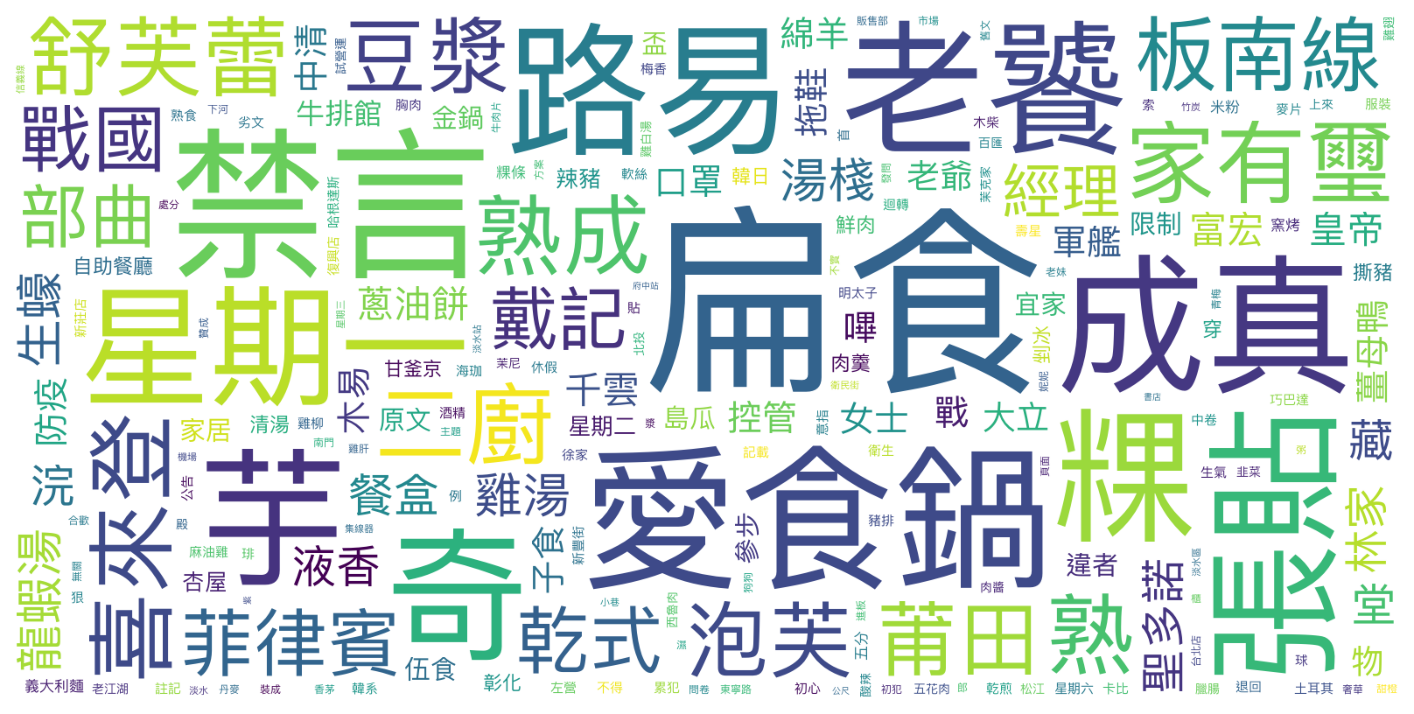

In [18]:
## Load stopwords
with open(
        '../../../RepositoryData/data/stopwords/tomlinNTUB-chinese-stopwords.txt'
) as f:
    stopwords = [w.strip() for w in f.readlines()]

# Create stopwords ad hoc
stopwords = set([
    '文章', '食記', '水桶', '刪除', '投票', '刪文', '連結', '板面', '板主', '規定', '違規', '使用',
    '所以', '禁止', '天', '票'
])

# Cutoff based on docfreq and stopwords
words2plot = dict([(w, tokens_freq[w]) for w, df in tokens_df.items()
                   if df < 2 and w not in stopwords and tokens_freq[w] >= 2])

wordcloud = WordCloud(font_path="/System/Library/Fonts/PingFang.ttc",
                      background_color='white',
                      stopwords=stopwords,
                      width=1600,
                      height=800,
                      margin=20)
# wordcloud.generate(' '.join([w for w in tokens_unnest if w not in stopwords]))
wordcloud.generate_from_frequencies(words2plot)
plt.figure(figsize=(20, 10), facecolor='w')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=1)
plt.show()
#plt.savefig('../data/twp-wordcloud2.png', facecolor='k', bbox_inches='tight')

:::{admonition} Exercise
How to seperate post texts from push texts?
:::
